# Detección de Parkinson

In [20]:
#from google.colab import files
#uploaded = files.upload()

In [21]:
#!unzip drawings_data.zip

In [22]:
#%cd drawings_data

In [23]:
# importar todos los paquetes necesarios
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature
from imutils import build_montages
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [24]:
#Función necesaria para desplegar imagenes en Jupyter y Google Colab
def plt_imshow(title, image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.figure(figsize=(15, 15))
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementación del sistema de detección

In [25]:
def quantify_image(image):
	# método para cuantificar las imágenes con el método HOG
	features = feature.hog(image, orientations=9,
		pixels_per_cell=(10, 10), cells_per_block=(2, 2),
		transform_sqrt=True, block_norm="L1")

	return features

In [26]:
# función cuyo propósito es tomar el camino a un dataset y regresa los datos asociados con sus etiquetas

def load_split(path):

	imagePaths = list(paths.list_images(path))
	data = []
	labels = []

	for imagePath in imagePaths:
		# extraer la etiqueta de la imagen, de su 'path'
		label = imagePath.split(os.path.sep)[-2]

		# cargar imagen, convertirla a escala de grises y ajustar su tamaño a 200X200
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image = cv2.resize(image, (200, 200))

		# cambiar imagen a blanco con fondo negro
		image = cv2.threshold(image, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

		# cuantificar la imagen
		features = quantify_image(image)

		# actualizar las listas de datos y etiquetas
		data.append(features)
		labels.append(label)

	# regresar listas como tupla
	return (np.array(data), np.array(labels))

In [27]:
args = {
	"dataset": "dataset/spiral",
    "trials": 5
}

In [28]:
# definir rutas a los directorios del dataset 
trainingPath = os.path.sep.join([args["dataset"], "training"])
testingPath = os.path.sep.join([args["dataset"], "testing"])

# cargar datos
print("Preparando datos...")
(trainX, trainY) = load_split(trainingPath)
(testX, testY) = load_split(testingPath)

# codificar etiquetas como datos numéricos
le = LabelEncoder()
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

trials = {}

Preparando datos...


In [29]:
# ciclo de procesamiento con base al número de 'trials'
for i in range(0, args["trials"]):
	# entrenar el modelo
	print("Entrenando modelo {} de {}...".format(i + 1,
		args["trials"]))
	model = RandomForestClassifier(n_estimators=100)
	model.fit(trainX, trainY)

	# Hacer prediciciones en con los datos de testeo y guardar las métricas
	predictions = model.predict(testX)
	metrics = {}

	# generar matriz de confusión y derivarla en precisión, sensibilidad y especificidad
	cm = confusion_matrix(testY, predictions).flatten()
	(tn, fp, fn, tp) = cm
	metrics["acc"] = (tp + tn) / float(cm.sum())
	metrics["sensitivity"] = tp / float(tp + fn)
	metrics["specificity"] = tn / float(tn + fp)

	# ciclo con las métricas
	for (k, v) in metrics.items():
		# actualizar el diccionario 'trials' con la lista de valores de la métrica actual
		l = trials.get(k, [])
		l.append(v)
		trials[k] = l

Entrenando modelo 1 de 5...
Entrenando modelo 2 de 5...
Entrenando modelo 3 de 5...
Entrenando modelo 4 de 5...
Entrenando modelo 5 de 5...


In [30]:
for metric in ("acc", "sensitivity", "specificity"):
	# acceder a los valores de cada métrica y después generar su promedio y desvición estandar
	values = trials[metric]
	mean = np.mean(values)
	std = np.std(values)

	# mostrar métricas
	print(metric)
	print("-" * len(metric))
	print("u={:.4f}, o={:.4f}".format(mean, std))
	print("")

acc
---
u=0.8000, o=0.0211

sensitivity
-----------
u=0.7067, o=0.0327

specificity
-----------
u=0.8933, o=0.0327



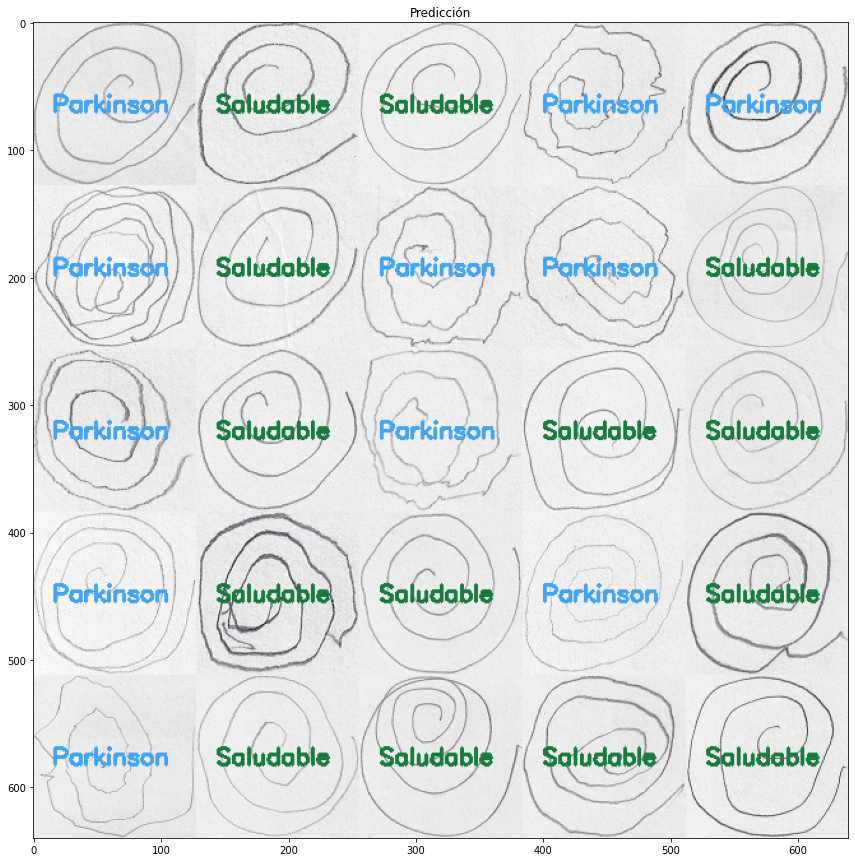

In [31]:
# seleccionar imágenes de testeo de forma aleatoria
testingPaths = list(paths.list_images(testingPath))
idxs = np.arange(0, len(testingPaths))
idxs = np.random.choice(idxs, size=(25,), replace=False)
images = []

for i in idxs:
	# cargar la imagen de testeo, clonarla y ajustarla
	image = cv2.imread(testingPaths[i])
	output = image.copy()
	output = cv2.resize(output, (128, 128))

	# pre-procesar la imagen de testeo
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	image = cv2.resize(image, (200, 200))
	image = cv2.threshold(image, 0, 255,
		cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

	# cuantificar imagen y generar predicciones basados en el modelo
	features = quantify_image(image)
	preds = model.predict([features])
	label = le.inverse_transform(preds)[0]

	if(label == "healthy"):
		outputLabel = "Saludable"
	else:
		outputLabel = "Parkinson"

	# sobreponer etiqueta de predicción en la imagen de testeo
	color = (62, 124, 23) if label == "healthy" else (244, 164, 66)
	cv2.putText(output, outputLabel, (15, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.6,
		color, 2)
	images.append(output)

# crear tabla de 5 filas y 5 columnas
montage = build_montages(images, (128, 128), (5, 5))[0]

# mostrar tabla
plt_imshow("Predicción", montage)